In [2]:
import matplotlib.pyplot as plt
import json
import glob
import re
import pandas as pd
import numpy as np

import qutip
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process

import multiprocessing
multiprocessing.set_start_method('spawn')

In [3]:
EJ = 3
EJoverEC = 6
EJoverEL = 25
EC = EJ / EJoverEC
EL = EJ / EJoverEL
n_lvls = 80
n_lvls_exp = 60
qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=n_lvls)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(n_lvls_exp)]

state_0_dressed = qutip.basis(qbt.truncated_dim, 1)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)

initial_states  = [
                state_0_dressed,
                state_1_dressed,
                ]

def do_experiment(amp, w_d, t_square,t_rise,plot=False):
    t_tot = t_square + 2*t_rise
    tlist = np.linspace(0, t_tot, 51)

    results = qbt.run_qutip_mesolve_parrallel(
                initial_states,
                [tlist],
                drive_terms=[[
                            DriveTerm(
                                driven_op=qutip.Qobj(
                                    qbt.fluxonium.n_operator(energy_esys=True)),
                                pulse_shape_func=square_pulse_with_rise_fall,
                                pulse_id='pi',
                                pulse_shape_args={
                                    "w_d": w_d,    # No extra 2pi factor
                                    "amp": amp,    # No extra 2pi factor
                                    't_square': t_square,
                                    "t_rise": t_rise,
                                },
                            )
                        ]],
                c_ops=None,
                e_ops=[e_ops],
    )[0]
    if plot:
        fig, axes = plt.subplots(1,2,figsize=(8,4))
        for exp_idx in range(len(e_ops)):
            axes[0].plot(tlist, results[0].expect[exp_idx],label= f"|{exp_idx}>")
        axes[0].set_yscale('log')

        for exp_idx in range(len(e_ops)):
            axes[1].plot(tlist, results[1].expect[exp_idx],label= f"|{exp_idx}>")
        axes[1].set_yscale('log')

    one_minus_pop2 = np.abs(1- results[0].expect[2][-1])
    one_minus_pop0 = np.abs(1- results[1].expect[1][-1])
    res = one_minus_pop2 + one_minus_pop0
    return res

0.018508693217925032

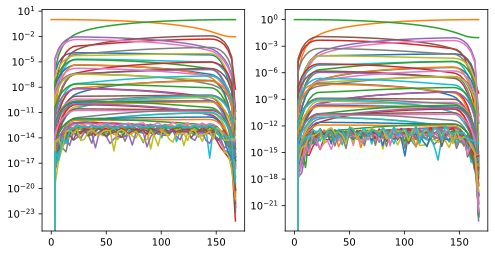

In [3]:
do_experiment(0.56679488, 0, 122.5, 22.5, plot=True)

In [18]:
from IPython.display import clear_output


old_amp = 0.533056378364563
old_t_rise_ratio = 0.024931317195296288

for t_tot in np.linspace(156, 150, 7):

    def objective_with_grad(x):
        amp, t_rise_ratio = x
        w_d = 0
        epsilon = 1e-3
        t_square = t_tot * (1 - 2 * t_rise_ratio)
        t_rise = t_tot * t_rise_ratio
        tlist = np.linspace(0, t_tot, 51)

        delta_amp = abs(amp*epsilon)
        amp_forward = amp + delta_amp
        amp_backward = amp - delta_amp

        delta_t_rise_ratio = abs(t_rise_ratio*epsilon)
        t_rise_ratio_forward = t_rise_ratio + delta_t_rise_ratio
        t_rise_ratio_backward = t_rise_ratio - delta_t_rise_ratio
        t_rise_forward = t_tot * t_rise_ratio_forward
        t_rise_backward = t_tot * t_rise_ratio_backward
        t_square_forward = t_tot * (1 - 2 * t_rise_ratio_forward)
        t_square_backward = t_tot * (1 - 2 * t_rise_ratio_backward)
        
        results_five_by_two = qbt.run_qutip_mesolve_parrallel(
                    initial_states,
                    [tlist for _ in range(5)],
                    drive_terms=[[ DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp_forward,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp_backward,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp,
                                        't_square': t_square_forward,
                                        "t_rise": t_rise_forward,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp,
                                        't_square': t_square_backward,
                                        "t_rise": t_rise_backward,
                                    }, )]
                            ],
                    c_ops=None,
                    e_ops=[e_ops for _ in range(5)],
                    )

        grad = np.zeros_like(x, dtype=float)

        obj_val = np.zeros((5,))
        for i, results in enumerate(results_five_by_two):
            one_minus_pop2 = np.abs(1- results[0].expect[2][-1])
            one_minus_pop0 = np.abs(1- results[1].expect[1][-1])
            res = one_minus_pop2 + one_minus_pop0
            obj_val[i] = res
        # print(obj_val)
        grad[0] = (obj_val[2] - obj_val[1]) / (2 * delta_amp)  
        grad[1] = (obj_val[4] - obj_val[3]) / (2 * delta_t_rise_ratio)
        print(f"t_tot: {t_tot}, fun: {obj_val[0]}, amp: {amp}, t_rise_ratio: {t_rise_ratio}")
        return obj_val[0], -grad

    def manual_nadam(x0, learning_rates, num_iterations=100, stop_threshold=1e-5, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Initialize parameters
        x = np.array(x0, dtype=np.float32)
        m = np.zeros_like(x)  # First moment (mean of gradients)
        v = np.zeros_like(x)  # Second moment (uncentered variance of gradients)
        t = 0  # Time step

        prev_loss = np.inf  # Store the loss value from the previous iteration
        best_loss = np.inf
        best_x = x
        for i in range(num_iterations):
            t += 1
            # Get the objective value and gradient
            obj_val, grad = objective_with_grad(x)
            if obj_val < best_loss:
                best_loss = obj_val
                best_x = x
            # Update biased first and second moment estimates
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * grad**2

            # Compute bias-corrected first and second moment estimates
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)

            # Apply Nesterov momentum
            m_nesterov = beta1 * m_hat + (1 - beta1) * grad

            # Update parameters with different learning rates
            x = x - learning_rates * m_nesterov / (np.sqrt(v_hat) + epsilon)

            # Check if the gradient is small enough to stop (optional condition)
            grad_norm = np.linalg.norm(grad)
            if grad_norm < stop_threshold:
                print(f"Stopping early: Gradient norm {grad_norm} is below threshold.")
                break

            # Check if the loss is changing too slowly (convergence)
            loss_diff = np.abs(prev_loss - obj_val)
            if loss_diff < stop_threshold:
                print(f"Stopping early: Loss difference {loss_diff} is below threshold.")
                break

            # Update the previous loss
            prev_loss = obj_val
        if best_loss < prev_loss:
            x = best_x
            prev_loss = best_loss
        return x, prev_loss  # Final optimized values
    
    x0 = [old_amp, old_t_rise_ratio]
    
    optimized_params, prev_loss = manual_nadam(x0, np.array([0.001,0.001]), num_iterations=90)
    last_amp, last_t_rise_ratio = optimized_params

    #Append result to file
    with open("results_flat_top_no_frequency_unique.json", "a") as f:
        json.dump({
            "t_tot": float(t_tot),
            "amp": float(last_amp),
            "w_d": float(0),
            "t_rise_ratio": float(last_t_rise_ratio),
            'fun': float(prev_loss)
        }, f)
        f.write("\n")

    #print result
    # clear_output(wait=True)
    print(f"t_tot: {t_tot}, fun: {prev_loss}, amp: {last_amp}, t_rise_ratio: {last_t_rise_ratio}")

    old_amp = last_amp
    old_t_rise_ratio = last_t_rise_ratio

t_tot: 156.0, fun: 0.00017428153945253655, amp: 0.533056378364563, t_rise_ratio: 0.024931317195296288
t_tot: 156.0, fun: 0.00012857890537087968, amp: 0.5320563789295486, t_rise_ratio: 0.02393131741420508
t_tot: 156.0, fun: 8.836029008807422e-05, amp: 0.5321739682399472, t_rise_ratio: 0.02293468345410482
t_tot: 156.0, fun: 6.0608435734743615e-05, amp: 0.5325254812917101, t_rise_ratio: 0.021967704777933438
t_tot: 156.0, fun: 4.5426226426448224e-05, amp: 0.5327327177385214, t_rise_ratio: 0.02107388987244619
t_tot: 156.0, fun: 3.036481965335014e-05, amp: 0.5326997612776566, t_rise_ratio: 0.020221818800560572
t_tot: 156.0, fun: 1.4922273107842443e-05, amp: 0.5325456827306267, t_rise_ratio: 0.01936717773940549
t_tot: 156.0, fun: 1.211595390104847e-05, amp: 0.5324104078900871, t_rise_ratio: 0.018577448842957443
Stopping early: Loss difference 2.8063192067939724e-06 is below threshold.
t_tot: 156.0, fun: 1.211595390104847e-05, amp: 0.5324104078900871, t_rise_ratio: 0.018577448842957443
t_tot: 

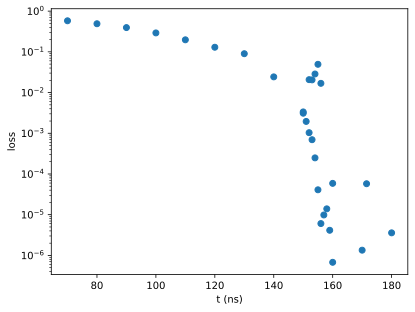

In [7]:
# load results_flat_top_no_frequency_unique.json
with open("results_flat_top_no_frequency_unique.json", "r") as f:
    results = [json.loads(line) for line in f]

result_t_tot_list = [result["t_tot"] for result in results]
result_fun_list = [result["fun"] for result in results]
# plot results
plt.scatter(result_t_tot_list, np.array(result_fun_list)/2)
plt.xlabel('t (ns)')
plt.ylabel("loss")
plt.yscale("log")
plt.show()